In [70]:
import numpy as np
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns


In [71]:
df = pd.read_csv("./Data/ASCII-comma/CH14/ex14-5.txt",",").reset_index(drop=True)
data = df.set_index('Worker')
data = data.stack()
data.index = data.index.rename('Plan', level=1)
data.name = 'Productivity'
data = data.reset_index()

In [72]:
l = data.shape[0]

In [73]:
# 1.a
# \(H_{0}:\) All incentive plan yield are having equal productivity.
# \(H_{a}:\) At least one incentive plan yields differing productivity.

In [74]:
# list all the 'plan's
a = df.T.loc['A']
b = df.T.loc['B']
c = df.T.loc['C']
d = df.T.loc['D']

In [34]:
# 1.b


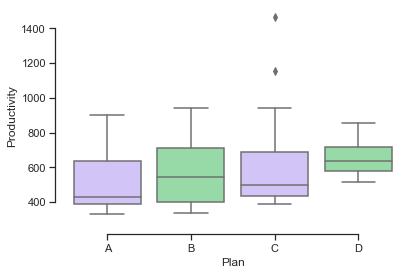

In [83]:
# 箱型图
sns.set(style="ticks", palette="pastel")

sns.boxplot(x="Plan", y="Productivity",
             palette=["m", "g"],
            data=data)
sns.despine(offset=10, trim=True)

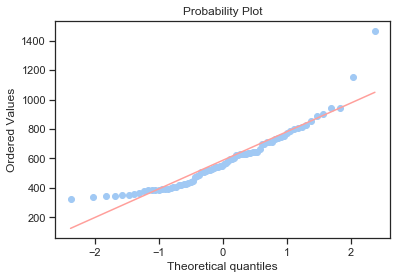

In [84]:
import pylab
from scipy import stats
stats.probplot(data['Productivity'], dist="norm", plot=pylab) # qq-plot
pylab.show()

In [87]:
l # > 50, 不适合用shap, < 300, 不适合用 ks

80

In [102]:
print(stats.shapiro(a)) # shapiro 检验 仅供参考
print(stats.shapiro(b))
print(stats.shapiro(c)) 
print(stats.shapiro(d)) 
print(stats.kstest(data['Productivity'], 'norm')) # k-s 检验 仅供参考


from statsmodels.stats.diagnostic import lilliefors
print(lilliefors(a)) # lilliefors 检验，部分不正态, so transfer
print(lilliefors(b))
print(lilliefors(c))
print(lilliefors(d))

(0.8754165172576904, 0.014648374170064926)
(0.9121683239936829, 0.07010561227798462)
(0.7844040393829346, 0.0005103913135826588)
(0.9617589116096497, 0.5795571804046631)
KstestResult(statistic=1.0, pvalue=0.0)
(0.23561738271242805, 0.004894712459462941)
(0.15998327393565404, 0.20223034130881642)
(0.24423866376526598, 0.0028592491848186525)
(0.12458838423274854, 0.5613769381604545)


In [93]:
import scipy.stats
scipy.stats.levene(a,b,c,d,center='median') # 方差齐次

LeveneResult(statistic=2.0619612832681455, pvalue=0.11230932572459755)

In [94]:
# transfer
x_most_normal, lmbda_optimal = stats.boxcox(data['Productivity'])

In [95]:
lmbda_optimal # ～ -0.5

-0.45754909812146655

In [105]:
print(stats.shapiro(a**(-0.5))) # shapiro 检验 仅供参考
print(stats.shapiro(b**(-0.5)))
print(stats.shapiro(c**(-0.5)))
print(stats.shapiro(d**(-0.5)))
print(stats.kstest(a**(-0.5), 'norm')) # k-s 检验 仅供参考
print(stats.kstest(b**(-0.5), 'norm'))
print(stats.kstest(c**(-0.5), 'norm'))
print(stats.kstest(d**(-0.5), 'norm'))

from statsmodels.stats.diagnostic import lilliefors
print(lilliefors(a**(-0.5))) # lilliefors 检验，依然会出现非正态
print(lilliefors(b**(-0.5)))
print(lilliefors(c**(-0.5)))
print(lilliefors(d**(-0.5)))

(0.9036062359809875, 0.048209335654973984)
(0.9325559139251709, 0.17291471362113953)
(0.903323233127594, 0.047620438039302826)
(0.9757245779037476, 0.8679212927818298)
KstestResult(statistic=0.5132882362454201, pvalue=2.0385013475828667e-05)
KstestResult(statistic=0.5129821731666143, pvalue=2.0682924717500763e-05)
KstestResult(statistic=0.5104146737720318, pvalue=2.334935614901855e-05)
KstestResult(statistic=0.513656855069704, pvalue=2.0031600341401467e-05)
(0.1948535105315502, 0.04508151672244269)
(0.13891915514687858, 0.39579788797958765)
(0.18515279686157915, 0.07071412290428916)
(0.08533160140148943, 0.9609490944999963)


In [104]:
scipy.stats.levene(a**(-0.5),b**(-0.5),c**(-0.5),d**(-0.5),center='median') # 如果变换，则方差不齐次，于是考虑 k-w test

LeveneResult(statistic=4.459544819937905, pvalue=0.006123299424499501)

In [41]:
model_str_0 = (('Productivity ~ C(Plan)'))
model_0 = ols(model_str_0, data=data).fit()
print(model.params)

Intercept       514.05
C(Plan)[T.B]     43.20
C(Plan)[T.C]    114.25
C(Plan)[T.D]    135.70
dtype: float64


In [42]:
# 又由于anova 在方差齐次的条件下有一定的容忍度，所以使用原数据：
anova_table_0 = sm.stats.anova_lm(model_0, typ=1).replace(np.nan, '', regex=True)
anova_table_0 

,df,sum_sq,mean_sq,F,PR(>F)
C(Plan),3.0,2.369912e+05,78997.079167,2.02039,0.118133
Residual,76.0,2.971587e+06,39099.824342,,


In [108]:
scipy.stats.kruskal(a,b,c,d) # 变换前后的数据不会对 k-w 有影响，所以使用原数据，p-value 《 0.05 ，由于 k-w 更加保守，所以认为正态性超过了 anova的容忍范围

KruskalResult(statistic=9.305435394246341, pvalue=0.025493876172639596)

In [ ]:
# 方差齐次


In [ ]:
# 1.c

In [113]:
# 由于方差齐次，且 tukey 不要求正态性
# tukey w
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

MultiComp = MultiComparison(data['Productivity'],
                            data['Plan'])
MultiComp.tukeyhsd().summary() # p-value 》 0。05， 所有pair的ci都包含0，所以没有配对在均值上有明显区别

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,43.2,0.8969,-121.0588,207.4588,False
A,C,114.25,0.2689,-50.0088,278.5088,False
A,D,135.7,0.1409,-28.5588,299.9588,False
B,C,71.05,0.6494,-93.2088,235.3088,False
B,D,92.5,0.4562,-71.7588,256.7588,False
C,D,21.45,0.9,-142.8088,185.7088,False


In [114]:
# 2.a
# 这我们之前就已经讨论过了，方差齐次性和正态性检验无法同时满足，且正态性检验始终无法满足。

In [118]:
# 2.b
# 由于正态性难以满足，考虑使用中位数评估的 bfl-test，考虑是 3组 与 control 组的方差区别，为了逻辑上的通顺，不使用四组同时进行 bfl 判断，而是三个组轮流和 control 比较：
print(scipy.stats.levene(a,b,center='median')) # 方差齐次
print(scipy.stats.levene(a,c,center='median'))
print(scipy.stats.levene(a,d,center='median')) # a-d 有显著性差异

LeveneResult(statistic=0.03465597431214312, pvalue=0.8533086355308221)
LeveneResult(statistic=0.704731756031713, pvalue=0.4064488609249448)
LeveneResult(statistic=4.42232000315996, pvalue=0.04214953428826169)


In [120]:
# 2.c 题目没看懂，本来考虑是做独立性检验，起初尝试做整体的正态性检验，然后发现这个论证方法没有道理，后来觉察到自己根本无法做独立性检验，所以在这里讲题目视作一个文字题：
# 答：因为这是同一生产线上的同一个工位，做着完全一样的事，在这种场景下进行实验，大家的生产力没有道理会互相影响。
# 2.d
# 之前我们已经解决了这个问题， 使用 Kruskal-Wallis 检验。